# IoT Network Intrusion Detection using CNN

This notebook implements a Convolutional Neural Network (CNN) to classify network traffic as **Normal** or **Anomaly** using the IoT Network Intrusion Dataset.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


## 2. Load and Explore Dataset

In [2]:
# Load the dataset
df = pd.read_csv('IoT Network Intrusion Dataset.csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nColumn names:")
print(df.columns.tolist())

FileNotFoundError: [Errno 2] No such file or directory: 'IoT Network Intrusion Dataset.csv'

In [ ]:
# Check target column (assuming it's named 'Label', 'Cat', or similar)
# Identify the target column - typically the last column or one containing attack types
target_column = None
for col in ['Label', 'Cat', 'label', 'cat', 'Attack_type', 'Class']:
    if col in df.columns:
        target_column = col
        break

if target_column is None:
    # Assume last column is the target
    target_column = df.columns[-1]

print(f"Target column: {target_column}")
print(f"\nClass distribution:")
print(df[target_column].value_counts())
print(f"\nUnique values in target: {df[target_column].unique()}")

Target column: Label

Class distribution:
Label
Anomaly    585710
Normal      40073
Name: count, dtype: int64

Unique values in target: ['Anomaly' 'Normal']


## 3. Data Preprocessing

Binary label distribution:
binary_label
1    585710
0     40073
Name: count, dtype: int64

Normal: 40073
Anomaly: 585710


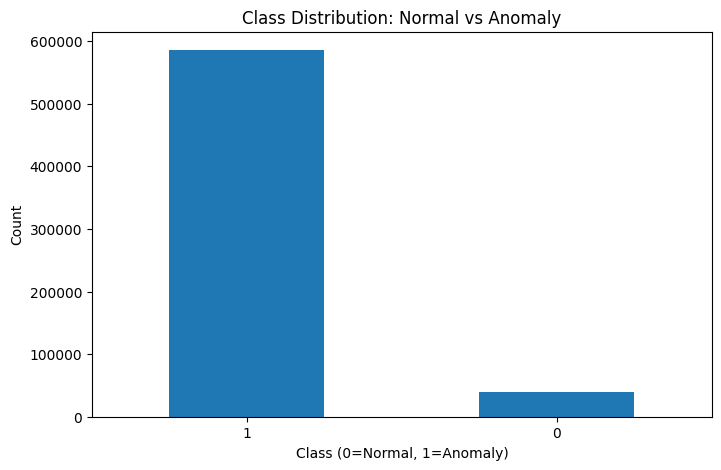

In [ ]:
# Convert target to binary: Normal (0) vs Anomaly (1)
# Assuming any attack type is anomaly and 'Normal' or similar is normal
df['binary_label'] = df[target_column].apply(
    lambda x: 0 if str(x).lower() in ['normal', '0', 'benign'] else 1
)

print("Binary label distribution:")
print(df['binary_label'].value_counts())
print(f"\nNormal: {(df['binary_label'] == 0).sum()}")
print(f"Anomaly: {(df['binary_label'] == 1).sum()}")

# Visualize class distribution
plt.figure(figsize=(8, 5))
df['binary_label'].value_counts().plot(kind='bar')
plt.title('Class Distribution: Normal vs Anomaly')
plt.xlabel('Class (0=Normal, 1=Anomaly)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Separate features and target
X = df.drop([target_column, 'binary_label'], axis=1)
y = df['binary_label']

# Handle non-numeric columns
# Identify numeric and non-numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numeric columns: {len(numeric_cols)}")
print(f"Non-numeric columns: {len(non_numeric_cols)}")
print(f"\nNon-numeric columns: {non_numeric_cols[:10]}")  # Show first 10

# Encode non-numeric columns
if non_numeric_cols:
    le = LabelEncoder()
    for col in non_numeric_cols:
        X[col] = le.fit_transform(X[col].astype(str))

# Handle missing values
X = X.fillna(0)

print(f"\nFinal feature shape: {X.shape}")
print(f"Target shape: {y.shape}")

Numeric columns: 79
Non-numeric columns: 6

Non-numeric columns: ['Flow_ID', 'Src_IP', 'Dst_IP', 'Timestamp', 'Cat', 'Sub_Cat']

Final feature shape: (625783, 85)
Target shape: (625783,)

Final feature shape: (625783, 85)
Target shape: (625783,)


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTesting set class distribution:")
print(y_test.value_counts())

Training set size: (500626, 85)
Testing set size: (125157, 85)

Training set class distribution:
binary_label
1    468568
0     32058
Name: count, dtype: int64

Testing set class distribution:
binary_label
1    117142
0      8015
Name: count, dtype: int64


In [ ]:
# Check for infinite values and replace them
print("Checking for infinite values...")
print(f"Infinite values in X_train: {np.isinf(X_train).sum().sum()}")
print(f"Infinite values in X_test: {np.isinf(X_test).sum().sum()}")

# Replace infinite values with NaN, then fill with 0
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Check for very large values and clip them
print("\nChecking for very large values...")
print(f"Max value in X_train: {X_train.max().max()}")
print(f"Min value in X_train: {X_train.min().min()}")

# Clip extreme values to a reasonable range
X_train = X_train.clip(-1e10, 1e10)
X_test = X_test.clip(-1e10, 1e10)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for CNN (samples, timesteps, features)
# For 1D CNN, we treat each feature as a timestep with 1 channel
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print(f"\nReshaped training data: {X_train_cnn.shape}")
print(f"Reshaped testing data: {X_test_cnn.shape}")
print(f"Input shape for CNN: {X_train_cnn.shape[1:]}")

Checking for infinite values...
Infinite values in X_train: 0
Infinite values in X_test: 0

Checking for very large values...
Max value in X_train: 4066000000.0

Checking for very large values...
Max value in X_train: 4066000000.0
Min value in X_train: -1.0
Min value in X_train: -1.0

Reshaped training data: (500626, 85, 1)
Reshaped testing data: (125157, 85, 1)
Input shape for CNN: (85, 1)

Reshaped training data: (500626, 85, 1)
Reshaped testing data: (125157, 85, 1)
Input shape for CNN: (85, 1)


## 4. Build CNN Model

In [ ]:
# Build CNN model
model = Sequential([
    # First Convolutional Block
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=X_train_cnn.shape[1:]),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # Second Convolutional Block
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # Third Convolutional Block
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    
    # Flatten and Dense Layers
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    # Output Layer (Binary Classification)
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Display model architecture
model.summary()

Model: "sequential"

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 83, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 83, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 41, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 41, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 39, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 39, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 19, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 17, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 17, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 396,417 (1.51 MB)

 Trainable params: 395,265 (1.51 MB)

 Non-trainable params: 1,152 (4.50 KB)

## 5. Train the Model (30 Epochs)

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Train the model with 10 epochs
history = model.fit(
    X_train_cnn, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nTraining completed!")

Epoch 1/10
6021/6258 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.9929 - loss: 0.0233 - precision: 0.9957 - recall: 0.9967

Epoch 1/10
6021/6258 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.9929 - loss: 0.0233 - precision: 0.9957 - recall: 0.9967

MemoryError: 

## 6. Visualize Training History

In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train Loss')
axes[0, 1].plot(history.history['val_loss'], label='Val Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision')
axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall')
axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

## 7. Model Evaluation

In [ ]:
# Evaluate on test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test_cnn, y_test, verbose=1)

print(f"\n{'='*50}")
print(f"Test Results:")
print(f"{'='*50}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"{'='*50}")

In [ ]:
# Make predictions
y_pred_prob = model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

# Calculate F1-Score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print(f"\nF1-Score: {f1:.4f}")

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display confusion matrix values
print("\nConfusion Matrix:")
print(f"True Negatives (Normal predicted as Normal): {cm[0, 0]}")
print(f"False Positives (Normal predicted as Anomaly): {cm[0, 1]}")
print(f"False Negatives (Anomaly predicted as Normal): {cm[1, 0]}")
print(f"True Positives (Anomaly predicted as Anomaly): {cm[1, 1]}")

## Summary

This notebook successfully implemented a CNN model for IoT Network Intrusion Detection with the following features:

- **Binary Classification**: Normal vs Anomaly
- **Model Architecture**: 3 Conv1D blocks with BatchNormalization and Dropout
- **Training**: 30 epochs with EarlyStopping and ReduceLROnPlateau callbacks
- **Evaluation Metrics**: Accuracy, Precision, Recall, F1-Score, and Confusion Matrix
- **Data Processing**: StandardScaler normalization and proper train-test split

The model can now be used to detect network intrusions in IoT environments.